In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import edhec_risk_kit as erk

ind = erk.get_ind_returns()
er = erk.annualize_rets(ind['1996':'2000'], 12)
cov = ind['1996':'2000'].cov()

In [9]:
from scipy.optimize import minimize

def msr(riskfree_rate, er, cov):
    """
    RiskFreeRate + ER + COV -> W
    """
    n = er.shape[0]
    init_guess = np.repeat(1/n, n) #equal weighting
    
    #Define Constraints
    bounds = ((0.0, 1.0), ) * n #makes n copies of the tuple
    weights_sum_to_1= {
        'type': 'eq',
        'fun': lambda weights: np.sum(weights) - 1
    }
    
    def neg_sharpe_ratio(weights, riskfree_rate, er, cov):
        """
        Returns negative of Sharpe Ratio, given weights
        """
        
        r = erk.portfolio_return(weights, er)
        vol = erk.portfolio_vol(weights, cov)
        return -(r - riskfree_rate) / vol
    
    
    results = minimize(neg_sharpe_ratio, init_guess,
                      args = (riskfree_rate, er, cov,), method = 'SLSQP',
                      options = {'disp': False},
                      constraints = (weights_sum_to_1),
                      bounds = bounds
                      )
    return results.x

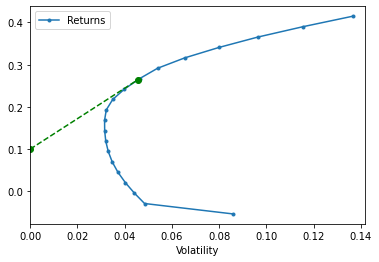

In [12]:
ax = erk.plot_ef(20, er, cov)
ax.set_xlim(left = 0)

#Calculate MSR
rf = .1
w_msr = msr(rf, er, cov)
r_msr = erk.portfolio_return(w_msr, er)
vol_msr = erk.portfolio_vol(w_msr, cov)

#Add CML
cml_1 = [0, vol_msr]
cml_2 = [rf, r_msr]
ax.plot(cml_1, cml_2, color = 'green', marker = 'o', linestyle='dashed')